In [1]:
!pip install python
!pip install pandas
!pip install datetime
!pip install xgboost

ERROR: Could not find a version that satisfies the requirement python (from versions: none)
ERROR: No matching distribution found for python


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import re

In [3]:
file_path = 'Clean_Dataset.csv'

In [4]:
business_df = pd.read_csv('business.csv')

business_df['class'] = 'business'

print(business_df.shape)

business_df.head(3)

(93487, 12)


,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,class
0,11-02-2022,Air India,AI,868,18:00,Delhi,02h 00m,non-stop,20:00,Mumbai,"25,612",business
1,11-02-2022,Air India,AI,624,19:00,Delhi,02h 15m,non-stop,21:15,Mumbai,"25,612",business
2,11-02-2022,Air India,AI,531,20:00,Delhi,24h 45m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,20:45,Mumbai,"42,220",business


In [5]:
economy_df = pd.read_csv('economy.csv')

economy_df['class'] = 'economy'

print(economy_df.shape)

economy_df.head(3)

(206774, 12)


,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,class
0,11-02-2022,SpiceJet,SG,8709,18:55,Delhi,02h 10m,non-stop,21:05,Mumbai,"5,953",economy
1,11-02-2022,SpiceJet,SG,8157,06:20,Delhi,02h 20m,non-stop,08:40,Mumbai,"5,953",economy
2,11-02-2022,AirAsia,I5,764,04:25,Delhi,02h 10m,non-stop,06:35,Mumbai,"5,956",economy


In [6]:
data_df = pd.concat([business_df, economy_df],ignore_index=True)

print(data_df.shape)

data_df.head(3)

(300261, 12)


,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,class
0,11-02-2022,Air India,AI,868,18:00,Delhi,02h 00m,non-stop,20:00,Mumbai,"25,612",business
1,11-02-2022,Air India,AI,624,19:00,Delhi,02h 15m,non-stop,21:15,Mumbai,"25,612",business
2,11-02-2022,Air India,AI,531,20:00,Delhi,24h 45m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,20:45,Mumbai,"42,220",business


In [7]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300261 entries, 0 to 300260
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   date        300261 non-null  object
 1   airline     300261 non-null  object
 2   ch_code     300261 non-null  object
 3   num_code    300261 non-null  int64 
 4   dep_time    300261 non-null  object
 5   from        300261 non-null  object
 6   time_taken  300261 non-null  object
 7   stop        300261 non-null  object
 8   arr_time    300261 non-null  object
 9   to          300261 non-null  object
 10  price       300261 non-null  object
 11  class       300261 non-null  object
dtypes: int64(1), object(11)
memory usage: 27.5+ MB


#### <font color='blue'>Data Cleaning</font>

In [8]:
def null_check(df):
    null_df = round(df.isnull().sum()/len(df)*100,2)
    print("Total Null value in the dataset: ",round(null_df.mean(),2))
    
null_check(data_df)

Total Null value in the dataset:  0.0


#### <font color='mustard'>1.Handle Datatypes and generating new features</font>

In [9]:
data_df.date.head()

0    11-02-2022
1    11-02-2022
2    11-02-2022
3    11-02-2022
4    11-02-2022
Name: date, dtype: object

In [10]:
#Handling the 'date' feature
data_df['date'] = data_df['date'].astype('datetime64[ns]')

#extracting the new features from the 'date' feature

data_df['Weekday'] = data_df['date'].dt.strftime('%A')
data_df['Month'] = data_df['date'].dt.month
data_df['Year'] = data_df['date'].dt.year

In [11]:
#Handling the price
data_df['price'] = data_df['price'].apply(lambda x: float(x.replace(',','')))

data_df['price'].head(3)

0    25612.0
1    25612.0
2    42220.0
Name: price, dtype: float64

In [12]:
#Number of stops 
data_df['stops'] = data_df['stop'].apply(lambda x: 0 if 'non-stop' in x else
                                                  1 if '1-stop' in x else
                                                  2 if '2+-stop' in x else
                                                  '>3')

<p>Mapping the departure timings and arrival timings :
    <br><br>
<li>Early Morning: 2:00 am to 5:59am </li>
<li>Morning : 6:00 am to 11:59am</li>
    <li>Afternoon : 12:00pm to 5:00pm</li>
    <li>Evening : 5:01pm to 8:00pm</li>
    <li>Night : 8:01pm to 2:00am</li>
    
</p>

In [13]:
def map_timetoday(df,col,new_col):
    
    df[new_col] = df[col].apply(lambda x: float(x.replace(':','.')))
    
    df[new_col] = df[new_col].apply(lambda x: 'Early_Morning' if x>2.0 and x<5.59 else
                                            'Morning' if x>5.59 and x<11.59 else
                                            'Afternoon' if x>12.0 and x<17.0 else
                                            'Evening' if x>17.0 and x<20.0 else
                                            'Night')
    return df

In [14]:
data_df = map_timetoday(data_df,'dep_time','departure_timing')

data_df = map_timetoday(data_df,'arr_time','arrival_timing')

data_df.head(3)

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,class,Weekday,Month,Year,stops,departure_timing,arrival_timing
0,2022-11-02,Air India,AI,868,18:00,Delhi,02h 00m,non-stop,20:00,Mumbai,25612.0,business,Wednesday,11,2022,0,Evening,Night
1,2022-11-02,Air India,AI,624,19:00,Delhi,02h 15m,non-stop,21:15,Mumbai,25612.0,business,Wednesday,11,2022,0,Evening,Night
2,2022-11-02,Air India,AI,531,20:00,Delhi,24h 45m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,20:45,Mumbai,42220.0,business,Wednesday,11,2022,1,Night,Night


In [15]:
data_df['duration_hr'] = data_df['time_taken'].apply(lambda x: round(float(x.split()[0].strip('h')) +(1/60 * float(x.split()[1].strip('m')+'0')/10),2))

In [16]:
data_df.head()

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,class,Weekday,Month,Year,stops,departure_timing,arrival_timing,duration_hr
0,2022-11-02,Air India,AI,868,18:00,Delhi,02h 00m,non-stop,20:00,Mumbai,25612.0,business,Wednesday,11,2022,0,Evening,Night,2.00
1,2022-11-02,Air India,AI,624,19:00,Delhi,02h 15m,non-stop,21:15,Mumbai,25612.0,business,Wednesday,11,2022,0,Evening,Night,2.25
2,2022-11-02,Air India,AI,531,20:00,Delhi,24h 45m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,20:45,Mumbai,42220.0,business,Wednesday,11,2022,1,Night,Night,24.75
3,2022-11-02,Air India,AI,839,21:25,Delhi,26h 30m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,23:55,Mumbai,44450.0,business,Wednesday,11,2022,1,Night,Night,26.50
4,2022-11-02,Air India,AI,544,17:15,Delhi,06h 40m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,23:55,Mumbai,46690.0,business,Wednesday,11,2022,1,Evening,Night,6.67


In [17]:
df =  data_df.drop(['date','dep_time','time_taken','arr_time'],axis=1)

df.head()

,airline,ch_code,num_code,from,stop,to,price,class,Weekday,Month,Year,stops,departure_timing,arrival_timing,duration_hr
0,Air India,AI,868,Delhi,non-stop,Mumbai,25612.0,business,Wednesday,11,2022,0,Evening,Night,2.00
1,Air India,AI,624,Delhi,non-stop,Mumbai,25612.0,business,Wednesday,11,2022,0,Evening,Night,2.25
2,Air India,AI,531,Delhi,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,Mumbai,42220.0,business,Wednesday,11,2022,1,Night,Night,24.75
3,Air India,AI,839,Delhi,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,Mumbai,44450.0,business,Wednesday,11,2022,1,Night,Night,26.50
4,Air India,AI,544,Delhi,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,Mumbai,46690.0,business,Wednesday,11,2022,1,Evening,Night,6.67


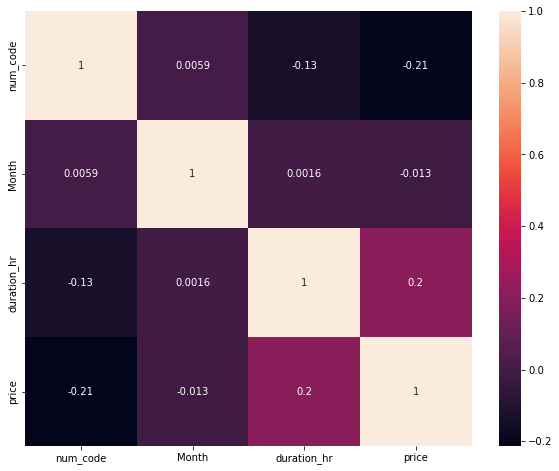

In [18]:
plt.figure(figsize=(10,8))
sns.heatmap(df[['num_code','stop','Weekday','Month','duration_hr','price']].corr(),annot=True)
plt.show()

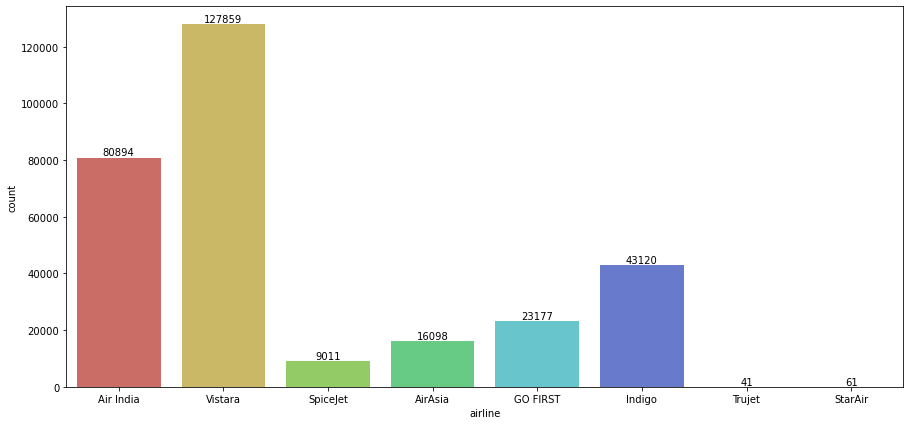

In [19]:
plt.figure(figsize=(15,7))
fig = sns.countplot(df['airline'],palette='hls')
fig.bar_label(fig.containers[0])
plt.show()

In [20]:
class_count = df['class'].value_counts().reset_index()

class_count

,index,class
0,economy,206774
1,business,93487


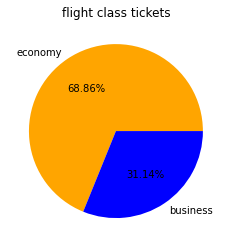

In [21]:

plt.figure(figsize=(10,4))

plt.pie(class_count['class'],labels=class_count['index'],autopct='%0.2f%%', colors=['orange','blue'])

plt.title('flight class tickets')

plt.show()

<AxesSubplot:xlabel='Weekday', ylabel='price'>

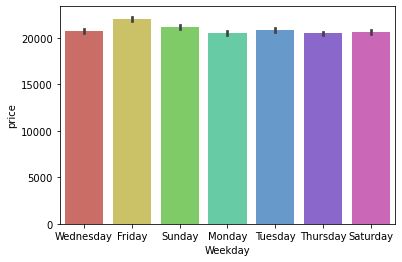

In [22]:
sns.barplot(data = df, x='Weekday', y='price', palette='hls')

<AxesSubplot:xlabel='Month', ylabel='price'>

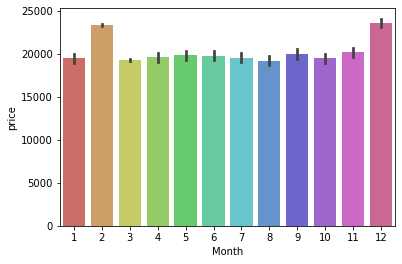

In [23]:
sns.barplot(data = df, x='Month', y='price', palette='hls')

<AxesSubplot:xlabel='departure_timing', ylabel='price'>

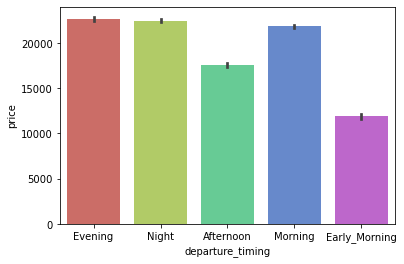

In [24]:
sns.barplot(data = df, x='departure_timing', y='price', palette='hls')

<AxesSubplot:xlabel='arrival_timing', ylabel='price'>

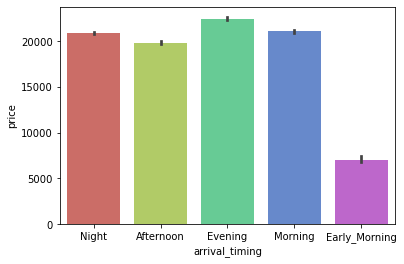

In [25]:
sns.barplot(data = df, x='arrival_timing', y='price', palette='hls')

<AxesSubplot:xlabel='to', ylabel='price'>

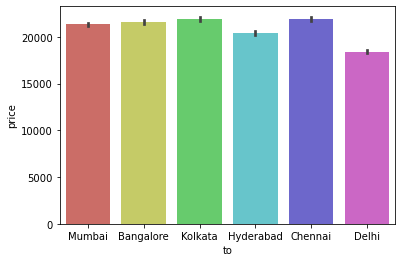

In [26]:
sns.barplot(data = df, x='to', y='price', palette='hls')

<AxesSubplot:xlabel='from', ylabel='price'>

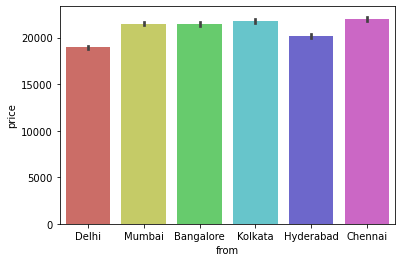

In [27]:
sns.barplot(data = df, x='from', y='price', palette='hls')

<AxesSubplot:xlabel='stops', ylabel='price'>

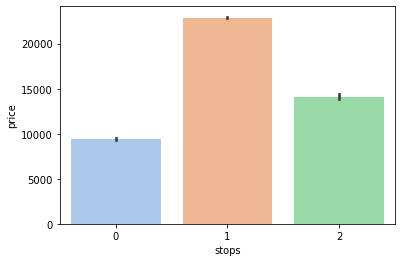

In [28]:
sns.barplot(data = df, x='stops', y='price', palette='pastel')

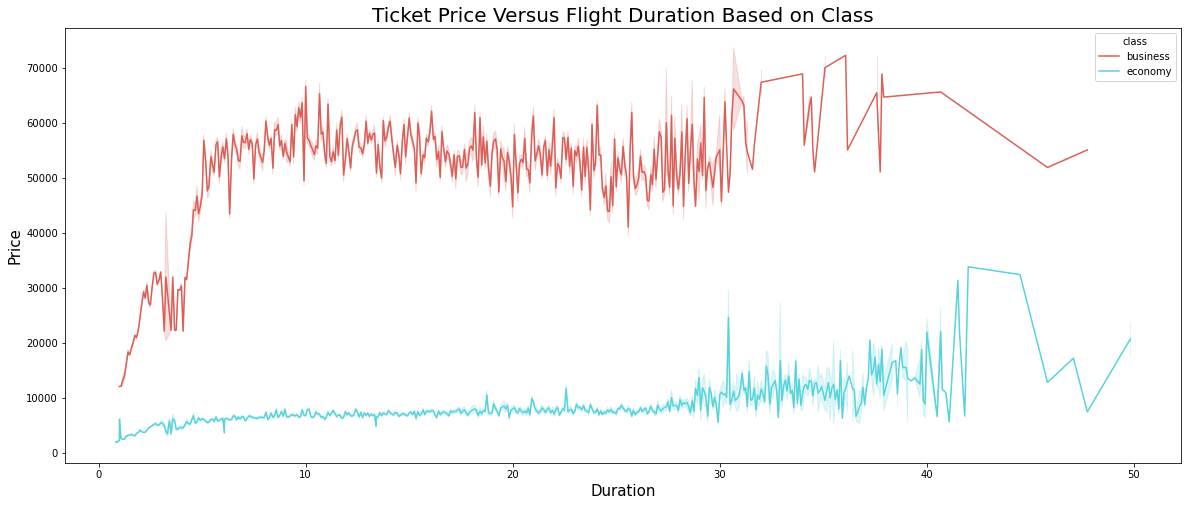

In [29]:
plt.figure(figsize=(20,8))
sns.lineplot(data=df,x='duration_hr',y='price',hue='class',palette='hls')
plt.title('Ticket Price Versus Flight Duration Based on Class',fontsize=20)
plt.xlabel('Duration',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

In [30]:
#df = pd.read_csv(file_path)

#Reading the Dataset

df= pd.read_csv('Clean_Dataset.csv')

df.head(5)

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [31]:
#Columns in the dataset
print("columns in Dataset :\n",df.columns.values,'\n')

df.info()

columns in Dataset :
 ['Unnamed: 0' 'airline' 'flight' 'source_city' 'departure_time' 'stops'
 'arrival_time' 'destination_city' 'class' 'duration' 'days_left' 'price'] 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory

In [32]:
df.describe()

,Unnamed: 0,duration,days_left,price
count,300153.000000,300153.000000,300153.000000,300153.000000
mean,150076.000000,12.221021,26.004751,20889.660523
std,86646.852011,7.191997,13.561004,22697.767366
min,0.000000,0.830000,1.000000,1105.000000
25%,75038.000000,6.830000,15.000000,4783.000000
50%,150076.000000,11.250000,26.000000,7425.000000
75%,225114.000000,16.170000,38.000000,42521.000000
max,300152.000000,49.830000,49.000000,123071.000000


<font color='blue'>Insights:</font>
<p>We have 11 features with 300153 entries. Our target feature is 'price' and other features are airline, flight, source city, depature time, stops in between, arrival time , class, duration... . Few of the features are of 'object' datatype which we might need to typecast</p>

#### <font color='blue'>Data Cleaning</font>

In [33]:
#Dropping 'Unamed: 0' column as it doesn't have any information
df.drop('Unnamed: 0', axis=1, inplace=True)
print("After dropping the 'Unamed:0' column from the dataset:\n")
df.head(2)

After dropping the 'Unamed:0' column from the dataset:



,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953


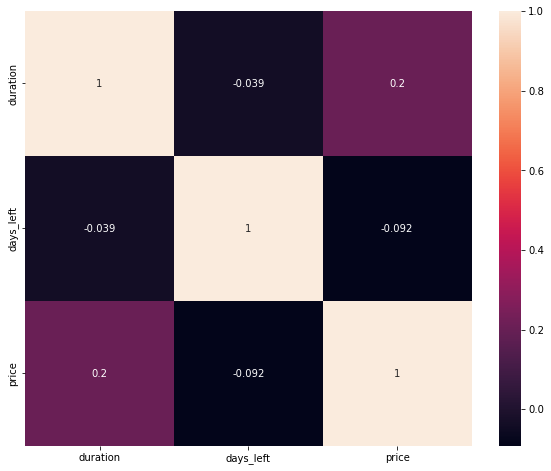

In [34]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(),annot=True)
plt.show()

In [35]:
df1=df.groupby(['flight','airline'],as_index=False).count()
df1.airline.value_counts()

Indigo       704
Air_India    218
GO_FIRST     205
SpiceJet     186
Vistara      133
AirAsia      115
Name: airline, dtype: int64

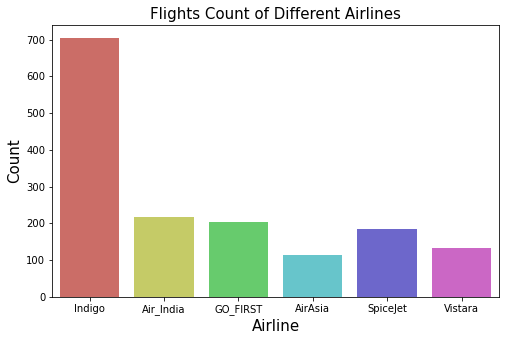

In [36]:
plt.figure(figsize=(8,5))
sns.countplot(df1['airline'],palette='hls')
plt.title('Flights Count of Different Airlines',fontsize=15)
plt.xlabel('Airline',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.show()

In [37]:
# so indigo has most flights

In [38]:
df2=df.groupby(['flight','airline','class'],as_index=False).count()
df2['class'].value_counts()

Economy     1560
Business     295
Name: class, dtype: int64

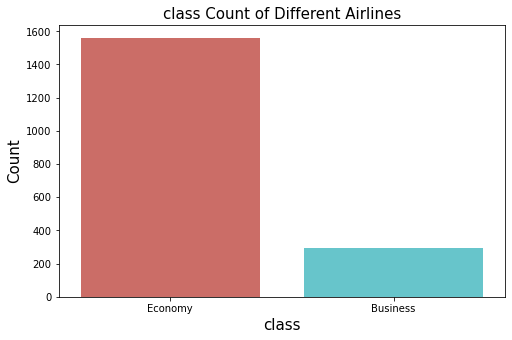

In [39]:
plt.figure(figsize=(8,5))
sns.countplot(df2['class'],palette='hls')
plt.title('class Count of Different Airlines',fontsize=15)
plt.xlabel('class',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.show()

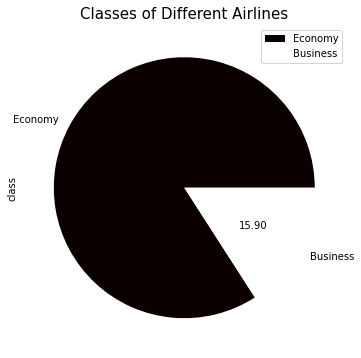

In [40]:
plt.figure(figsize=(8,6))
df2['class'].value_counts().plot(kind='pie',textprops={'color':'black'},autopct='%.2f',cmap='hot')
plt.title('Classes of Different Airlines',fontsize=15)
plt.legend(['Economy','Business'])
plt.show()

In [41]:
# Economy class in present in almost all the airlines

In [42]:
# airlines vs cost

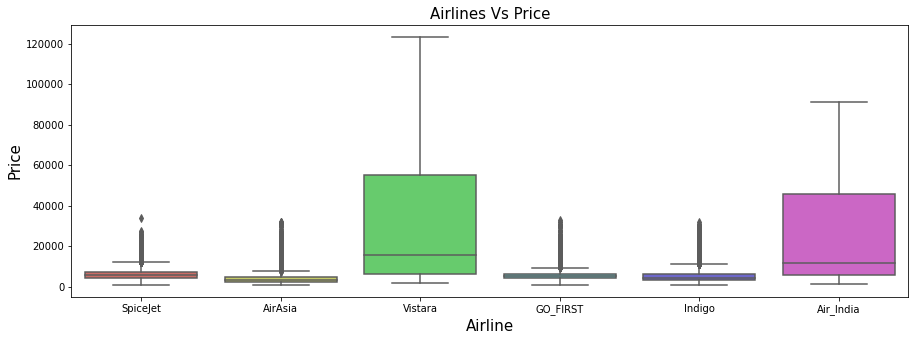

In [43]:
plt.figure(figsize=(15,5))
sns.boxplot(x=df['airline'],y=df['price'],palette='hls')
plt.title('Airlines Vs Price',fontsize=15)
plt.xlabel('Airline',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

In [44]:
# visatara and air india has maximum prices remaining airlines are economical

In [45]:
# business class vs economy class price difference

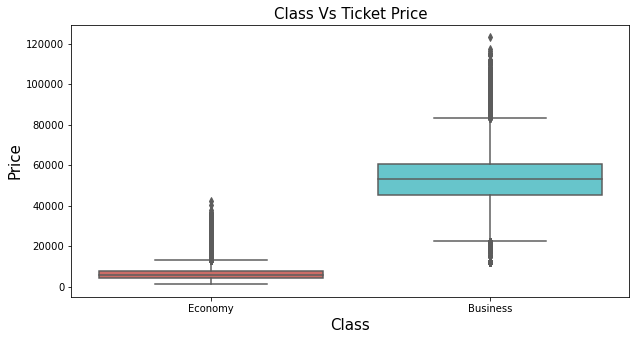

In [46]:
plt.figure(figsize=(10,5))
sns.boxplot(x='class',y='price',data=df,palette='hls')
plt.title('Class Vs Ticket Price',fontsize=15)
plt.xlabel('Class',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()


In [47]:
# does no of stops have an impact on price


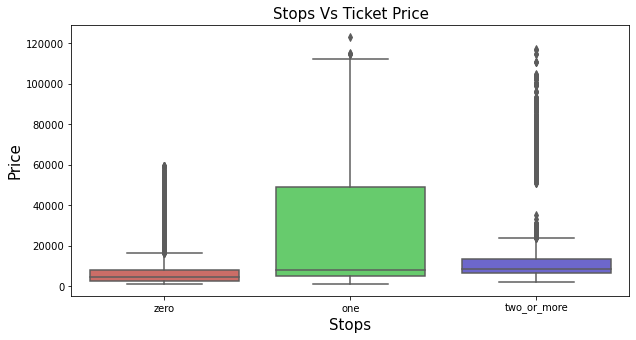

In [48]:
plt.figure(figsize=(10,5))
sns.boxplot(x=df.stops,y=df.price,data=df,palette='hls')
plt.title('Stops Vs Ticket Price',fontsize=15)
plt.xlabel('Stops',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

In [49]:
# so if stop is 1 you have max price on the ticket 

In [50]:
# How the Ticket Price change based on the Departure Time and Arrival Time?
# 1. Departure Time Vs Ticket Price

# Ticket Price is More for the Flights when the Departure Time is at Night
# Ticket Price is almost equal for flights Having Departure time at Early_morning , Morning and Evening
# Ticket Price is Low for the Flights Having Departure Time at Late_night
# 2. Arrival Time Vs Ticket Price
# Ticket Price is More for the Flights when the Arrival Time is at Evening
# Ticket Price is almost equal for flights Having Arrival time is at Morning and Night
# Ticket Price is Low for the Flights Having Arrival Time at Late_night as same as Departure Time

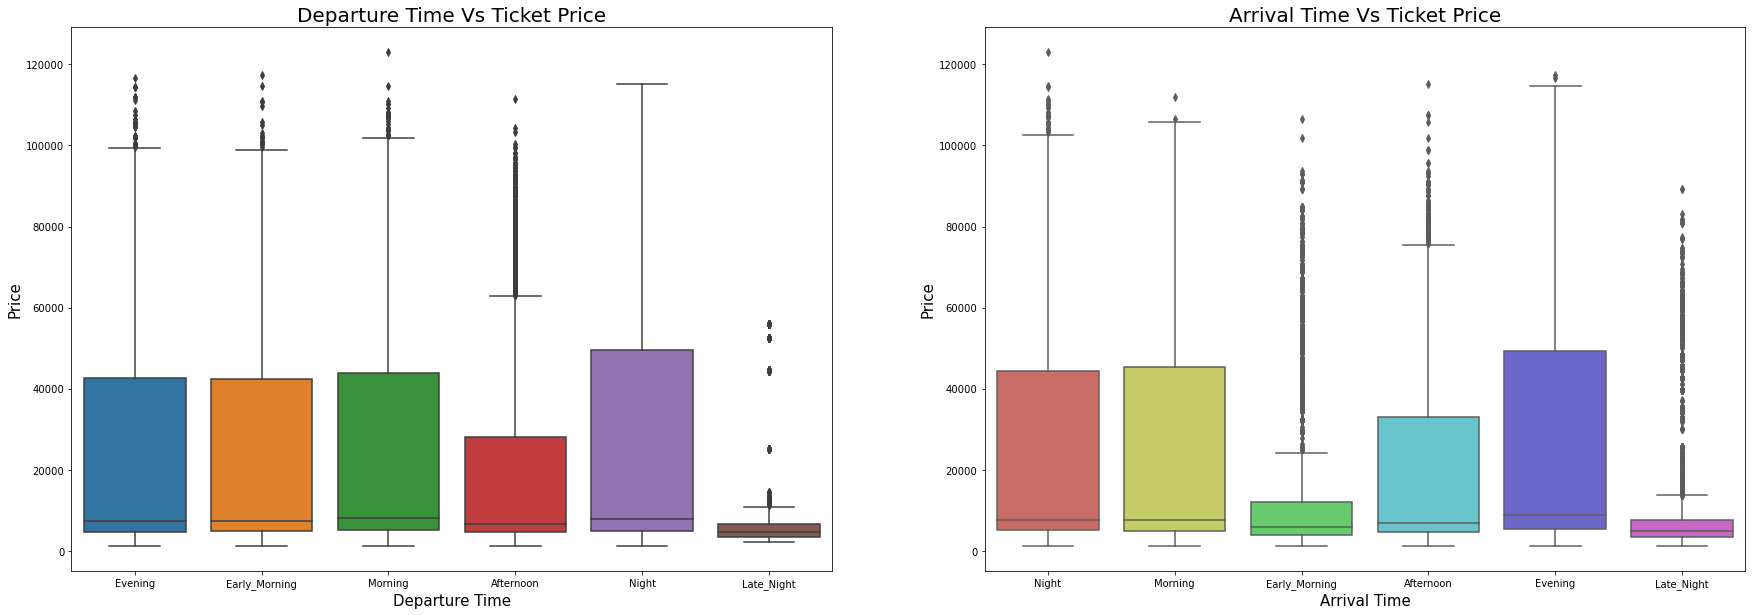

In [51]:
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
sns.boxplot(x='departure_time',y='price',data=df)
plt.title('Departure Time Vs Ticket Price',fontsize=20)
plt.xlabel('Departure Time',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.subplot(1,2,2)
sns.boxplot(x='arrival_time',y='price',data=df,palette='hls')
plt.title('Arrival Time Vs Ticket Price',fontsize=20)
plt.xlabel('Arrival Time',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

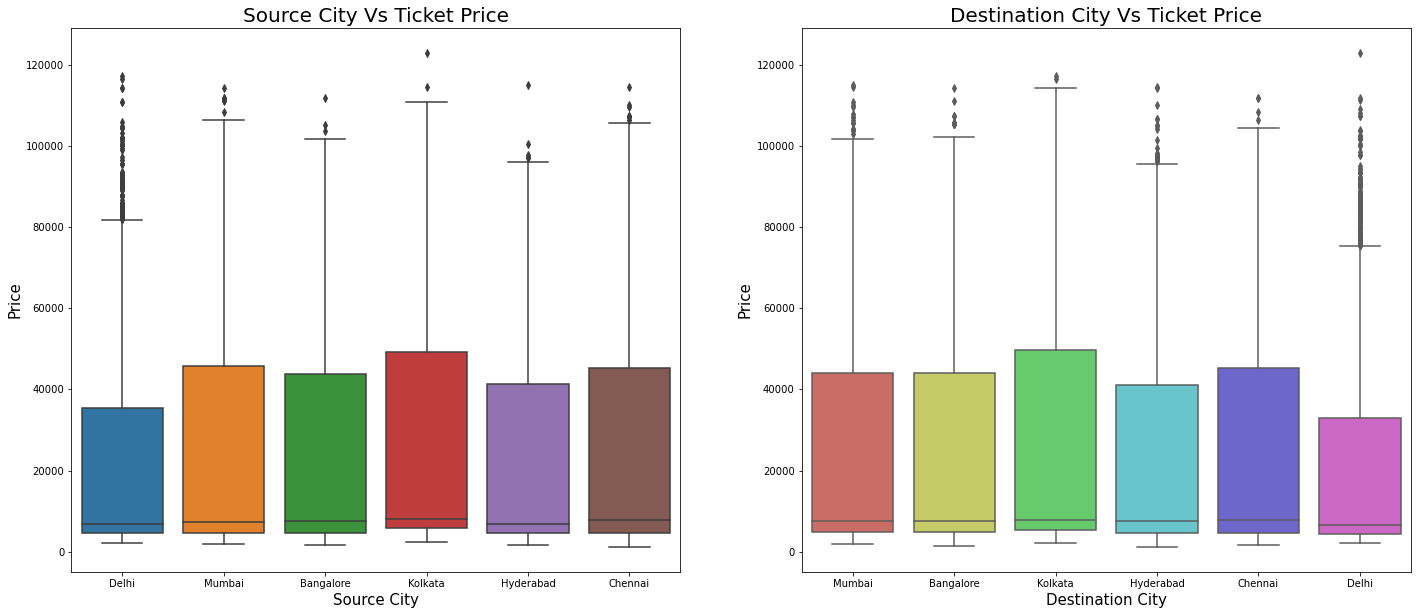

In [52]:
plt.figure(figsize=(24,10))
plt.subplot(1,2,1)
sns.boxplot(x='source_city',y='price',data=df)
plt.title('Source City Vs Ticket Price',fontsize=20)
plt.xlabel('Source City',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.subplot(1,2,2)
sns.boxplot(x='destination_city',y='price',data=df,palette='hls')
plt.title('Destination City Vs Ticket Price',fontsize=20)
plt.xlabel('Destination City',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

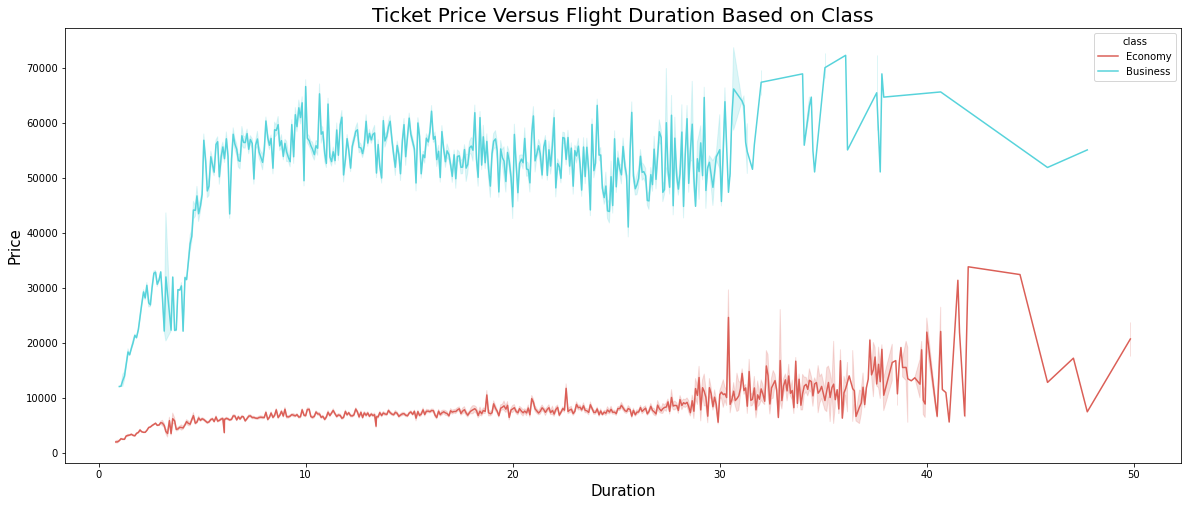

In [53]:
plt.figure(figsize=(20,8))
sns.lineplot(data=df,x='duration',y='price',hue='class',palette='hls')
plt.title('Ticket Price Versus Flight Duration Based on Class',fontsize=20)
plt.xlabel('Duration',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

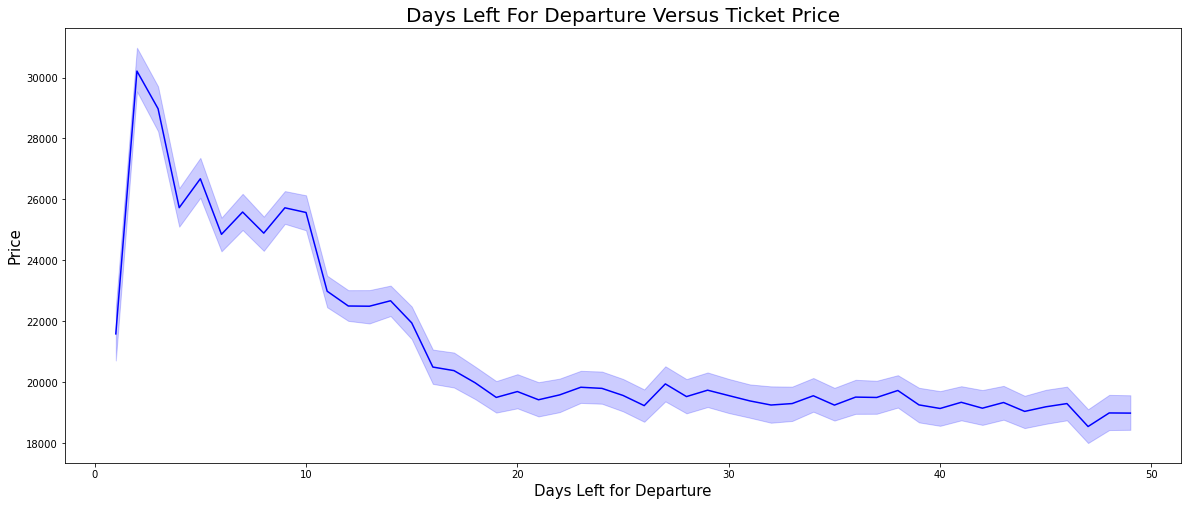

In [54]:
plt.figure(figsize=(20,8))
sns.lineplot(data=df,x='days_left',y='price',color='blue')
plt.title('Days Left For Departure Versus Ticket Price',fontsize=20)
plt.xlabel('Days Left for Departure',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

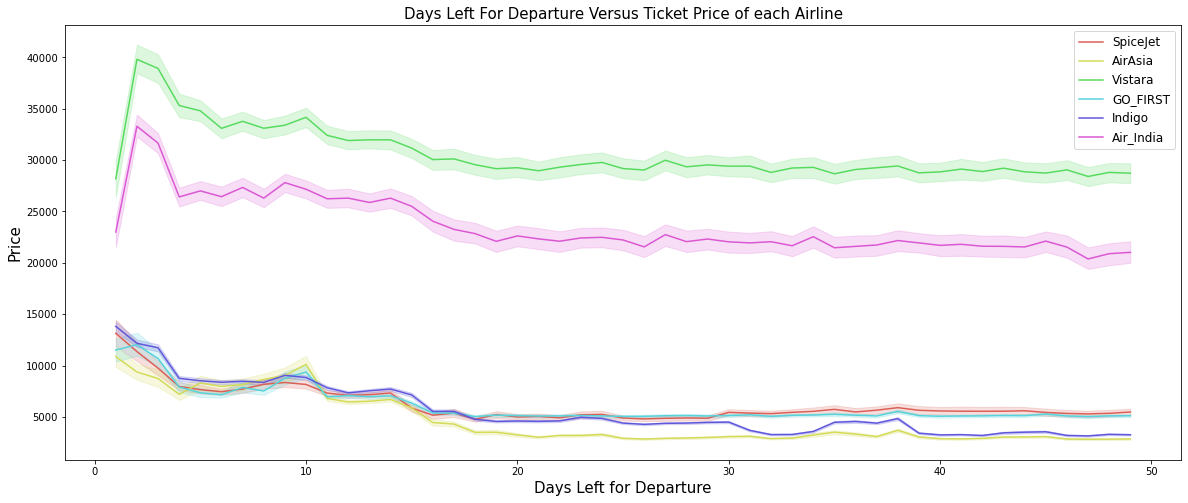

In [55]:
plt.figure(figsize=(20,8))
sns.lineplot(data=df,x='days_left',y='price',color='blue',hue='airline',palette='hls')
plt.title('Days Left For Departure Versus Ticket Price of each Airline',fontsize=15)
plt.legend(fontsize=12)
plt.xlabel('Days Left for Departure',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

In [56]:
# total flights from cities 

In [57]:
df.groupby(['flight','source_city','destination_city','airline','class'],as_index=False).count().groupby(['source_city','destination_city'],as_index=False)['flight'].count().head(10)

,source_city,destination_city,flight
0,Bangalore,Chennai,106
1,Bangalore,Delhi,227
2,Bangalore,Hyderabad,132
3,Bangalore,Kolkata,171
4,Bangalore,Mumbai,175
5,Chennai,Bangalore,69
6,Chennai,Delhi,105
7,Chennai,Hyderabad,82
8,Chennai,Kolkata,110
9,Chennai,Mumbai,94


In [58]:
# mean price difference of flights

In [59]:
df.groupby(['airline','source_city','destination_city'],as_index=False)['price'].mean().head(10)

,airline,source_city,destination_city,price
0,AirAsia,Bangalore,Chennai,2073.043478
1,AirAsia,Bangalore,Delhi,4807.092426
2,AirAsia,Bangalore,Hyderabad,2931.494792
3,AirAsia,Bangalore,Kolkata,4443.468160
4,AirAsia,Bangalore,Mumbai,3342.385350
5,AirAsia,Chennai,Bangalore,1914.760870
6,AirAsia,Chennai,Delhi,3697.314003
7,AirAsia,Chennai,Hyderabad,2053.182540
8,AirAsia,Chennai,Kolkata,3682.338762
9,AirAsia,Chennai,Mumbai,2691.100000


In [60]:
# how to find outliers?

In [61]:
# now checking outliers for price 
df.price.nunique()

12157

In [62]:
df.price.value_counts()

54608    1445
2339     1442
54684    1390
60978    1383
60508    1230
         ... 
12014       1
26912       1
20145       1
25462       1
7533        1
Name: price, Length: 12157, dtype: int64

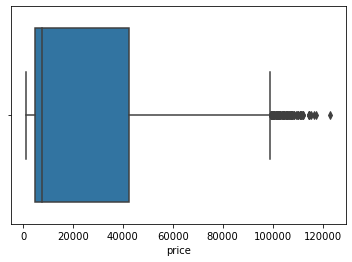

In [63]:
sns.boxplot(x=df['price'])
plt.show()

<AxesSubplot:xlabel='days_left'>

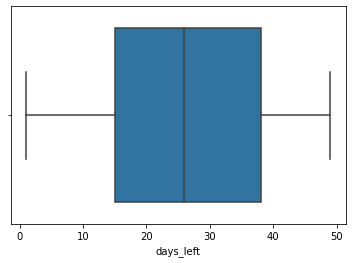

In [64]:
sns.boxplot(x=df.days_left)

In [65]:
# identifying outliers using a IQR

In [66]:
df_bk = df.copy()
df_bk.head(10)

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955
5,Vistara,UK-945,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.33,1,5955
6,Vistara,UK-927,Delhi,Morning,zero,Morning,Mumbai,Economy,2.08,1,6060
7,Vistara,UK-951,Delhi,Afternoon,zero,Evening,Mumbai,Economy,2.17,1,6060
8,GO_FIRST,G8-334,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.17,1,5954
9,GO_FIRST,G8-336,Delhi,Afternoon,zero,Evening,Mumbai,Economy,2.25,1,5954


In [67]:
Q1 = df_bk.quantile(0.25)
Q3 = df_bk.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

duration         9.34
days_left       23.00
price        37738.00
dtype: float64


In [68]:
# detecting with outliers

In [69]:
# print(df_bk < (Q1 - 1.5 * IQR)) |(df_bk > (Q3 + 1.5 * IQR))

In [70]:
df_bk_out = df_bk[~((df_bk < (Q1 - 1.5 * IQR)) |(df_bk > (Q3 + 1.5 * IQR))).any(axis=1)]
df_bk_out.shape

(297920, 11)

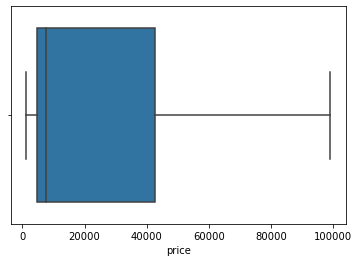

In [71]:
sns.boxplot(x=df_bk_out['price'])
plt.show()

In [72]:
# removing some of the outliers through this method makes the model better

In [73]:
# now Creating a test df with next flight prices for the next 30 days

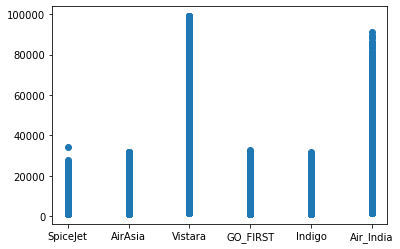

In [74]:
fig = plt.scatter(x=df_bk_out['airline'], y=df_bk_out['price'])
plt.show()


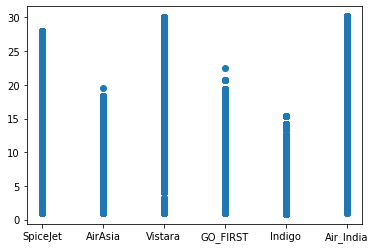

In [75]:
fig = plt.scatter(x=df_bk_out['airline'], y=df_bk_out['duration'])
plt.show()

In [76]:
def find_outliers_IQR(df):
    
    one=df.quantile(0.25)

    three=df.quantile(0.75)

    IQR=three-one

    outliers = df[((df<(one-1.5*IQR)) | (df>(three+1.5*IQR)))]
    
    return outliers

In [77]:
outliers = find_outliers_IQR(df_bk_out["days_left"])

print('number of outliers: '+ str(len(outliers)))

print('max outlier value: '+ str(outliers.max()))

print('min outlier value: '+ str(outliers.min()))

outliers

number of outliers: 0
max outlier value: nan
min outlier value: nan


Series([], Name: days_left, dtype: int64)

In [78]:
outliers = find_outliers_IQR(df_bk_out["price"])

print('number of outliers: '+ str(len(outliers)))

print('max outlier value: '+ str(outliers.max()))

print('min outlier value: '+ str(outliers.min()))

outliers

number of outliers: 0
max outlier value: nan
min outlier value: nan


Series([], Name: price, dtype: int64)

In [79]:
input_cols = list(df_bk.columns[0:-1])
target_col = 'price'

In [80]:
input_cols

['airline',
 'flight',
 'source_city',
 'departure_time',
 'stops',
 'arrival_time',
 'destination_city',
 'class',
 'duration',
 'days_left']

In [81]:
target_col

'price'

In [82]:
inputs_df = df_bk[input_cols].copy()
targets_df = df_bk[target_col].copy()

In [83]:
numeric_cols= inputs_df.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = inputs_df.select_dtypes(include=['object']).columns.tolist()

In [84]:
# final check for null values 
inputs_df.isnull().sum()

airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
dtype: int64

In [85]:
inputs_df[numeric_cols].describe().loc[['min','max']]

,duration,days_left
min,0.83,1.0
max,49.83,49.0


In [86]:
# Scaling numeric values 
from sklearn.preprocessing import MinMaxScaler
# create a scaler
scaler = MinMaxScaler()
# fit the scaler to numeric cols 
scaler.fit(inputs_df[numeric_cols])
MinMaxScaler()
# transform and replace numeric cols
inputs_df[numeric_cols]=scaler.transform(inputs_df[numeric_cols])

In [87]:
inputs_df[numeric_cols].describe().loc[['min','max']]

,duration,days_left
min,0.0,0.0
max,1.0,1.0


In [88]:
# Encoding categorical variables
inputs_df[categorical_cols].nunique().sort_values(ascending=True)

class                  2
stops                  3
airline                6
source_city            6
departure_time         6
arrival_time           6
destination_city       6
flight              1561
dtype: int64

In [89]:
categorical_cols

['airline',
 'flight',
 'source_city',
 'departure_time',
 'stops',
 'arrival_time',
 'destination_city',
 'class']

In [90]:
categorical_cols_1=['airline',
 'source_city',
 'departure_time',
 'stops',
 'arrival_time',
 'destination_city',
 'class']
categorical_cols_2 = ['flight']


In [91]:
# As there are 1561 unique values for flight columns, I am using target encoding to reduce dimensionality of the dateset
from sklearn.preprocessing import LabelEncoder
encoder_1 = LabelEncoder()
# Assigning numerical values and storing in another column
inputs_df["flight"] = encoder_1.fit_transform(inputs_df["flight"])

# encoding other features in one hot encoding 
from sklearn.preprocessing import OneHotEncoder
encoder_2 = OneHotEncoder(sparse=False,handle_unknown='ignore')
encoder_2.fit(inputs_df[categorical_cols_1])
encoded_cols = list(encoder_2.get_feature_names(categorical_cols_1))
len(encoded_cols)

35

In [92]:
# As there are 1561 unique values for flight columns, I am using target encoding to reduce dimensionality of the dateset
from sklearn.preprocessing import LabelEncoder
encoder_1 = LabelEncoder()
# Assigning numerical values and storing in another column
inputs_df["flight"] = encoder_1.fit_transform(inputs_df["flight"])

# encoding other features in one hot encoding 
from sklearn.preprocessing import OneHotEncoder
encoder_2 = OneHotEncoder(sparse=False,handle_unknown='ignore')
encoder_2.fit(inputs_df[categorical_cols_1])
encoded_cols = list(encoder_2.get_feature_names(categorical_cols_1))
len(encoded_cols)

35

In [93]:
inputs_df["flight"].value_counts()

1442    3235
1454    2741
1445    2650
1490    2542
1477    2468
        ... 
1426       1
487        1
647        1
1083       1
927        1
Name: flight, Length: 1561, dtype: int64

In [94]:
inputs_df[categorical_cols_1].nunique().sort_values()

class               2
stops               3
airline             6
source_city         6
departure_time      6
arrival_time        6
destination_city    6
dtype: int64

In [95]:
inputs_df

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left
0,SpiceJet,1408,Delhi,Evening,zero,Night,Mumbai,Economy,0.027347,0.0
1,SpiceJet,1387,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,0.030612,0.0
2,AirAsia,1213,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,0.027347,0.0
3,Vistara,1559,Delhi,Morning,zero,Afternoon,Mumbai,Economy,0.028980,0.0
4,Vistara,1549,Delhi,Morning,zero,Morning,Mumbai,Economy,0.030612,0.0
...,...,...,...,...,...,...,...,...,...,...
300148,Vistara,1477,Chennai,Morning,one,Evening,Hyderabad,Business,0.188776,1.0
300149,Vistara,1481,Chennai,Afternoon,one,Night,Hyderabad,Business,0.195714,1.0
300150,Vistara,1486,Chennai,Early_Morning,one,Night,Hyderabad,Business,0.265306,1.0
300151,Vistara,1483,Chennai,Early_Morning,one,Evening,Hyderabad,Business,0.187143,1.0


In [96]:
inputs_df[encoded_cols] = encoder_2.transform(inputs_df[categorical_cols_1])
inputs_df

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,...,arrival_time_Morning,arrival_time_Night,destination_city_Bangalore,destination_city_Chennai,destination_city_Delhi,destination_city_Hyderabad,destination_city_Kolkata,destination_city_Mumbai,class_Business,class_Economy
0,SpiceJet,1408,Delhi,Evening,zero,Night,Mumbai,Economy,0.027347,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,SpiceJet,1387,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,0.030612,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,AirAsia,1213,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,0.027347,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,Vistara,1559,Delhi,Morning,zero,Afternoon,Mumbai,Economy,0.028980,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,Vistara,1549,Delhi,Morning,zero,Morning,Mumbai,Economy,0.030612,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300148,Vistara,1477,Chennai,Morning,one,Evening,Hyderabad,Business,0.188776,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
300149,Vistara,1481,Chennai,Afternoon,one,Night,Hyderabad,Business,0.195714,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
300150,Vistara,1486,Chennai,Early_Morning,one,Night,Hyderabad,Business,0.265306,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
300151,Vistara,1483,Chennai,Early_Morning,one,Evening,Hyderabad,Business,0.187143,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [97]:
from sklearn.model_selection import train_test_split
train_inputs, val_inputs, train_targets, val_targets = train_test_split(inputs_df[numeric_cols + encoded_cols+categorical_cols_2], 
                                                                        targets_df, 
                                                                        test_size=0.25, 
                                                                        random_state=42)

In [98]:
train_inputs

,duration,days_left,airline_AirAsia,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,source_city_Bangalore,source_city_Chennai,...,arrival_time_Night,destination_city_Bangalore,destination_city_Chennai,destination_city_Delhi,destination_city_Hyderabad,destination_city_Kolkata,destination_city_Mumbai,class_Business,class_Economy,flight
298245,0.523878,0.125000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1477
210650,0.494898,0.770833,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,735
38033,0.512041,0.395833,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,820
270667,0.420204,0.208333,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1454
248464,0.192245,0.958333,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,0.401429,0.020833,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1458
259178,0.501837,0.125000,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1513
131932,0.262041,0.583333,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,846
146867,0.153061,0.791667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,924


In [99]:
val_inputs

,duration,days_left,airline_AirAsia,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,source_city_Bangalore,source_city_Chennai,...,arrival_time_Night,destination_city_Bangalore,destination_city_Chennai,destination_city_Delhi,destination_city_Hyderabad,destination_city_Kolkata,destination_city_Mumbai,class_Business,class_Economy,flight
27131,0.386122,0.812500,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,748
266857,0.183673,0.854167,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1442
141228,0.197347,0.833333,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1454
288329,0.278980,0.270833,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1479
97334,0.151429,0.395833,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104184,0.477959,0.229167,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,745
93137,0.042653,0.916667,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1415
50649,0.336735,0.791667,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1519
277630,0.132653,0.145833,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1485


In [100]:
from sklearn.linear_model import Ridge
# Create the model
model =Ridge(alpha=1.0)
# Fit the model using inputs and targets
model.fit(train_inputs,train_targets)

Ridge()

In [101]:
from sklearn.metrics import mean_squared_error
train_preds = model.predict(train_inputs)
train_preds

array([55955.54359113, 48758.67527832,  5922.7206202 , ...,
        7165.71739089,  5760.70876945,  6879.44200603])

In [102]:
train_rmse = mean_squared_error(train_targets,train_preds,squared=False)
print('The RMSE loss for the training set is $ {}.'.format(train_rmse))





The RMSE loss for the training set is $ 6753.0708664137155.


In [103]:
val_preds = model.predict(val_inputs)
val_preds

array([ 3513.88408263, 55191.26762079, 10465.52994732, ...,
        6346.48791506, 56020.88773499, -2795.20425844])

In [104]:
val_rmse = mean_squared_error(val_targets,val_preds,squared=False)
print('The RMSE loss for the validation set is $ {}.'.format(val_rmse))

The RMSE loss for the validation set is $ 6753.705039306168.


In [105]:
weights = model.coef_.flatten().tolist()
weights_df = pd.DataFrame({
    'columns': train_inputs.columns,
    'weight': weights
}).sort_values('weight', ascending=False)
weights_df

,columns,weight
35,class_Business,22463.739952
21,stops_two_or_more,3938.414716
7,airline_Vistara,2962.893302
0,duration,2128.268139
12,source_city_Kolkata,1876.711002
20,stops_one,1849.971554
33,destination_city_Kolkata,1731.198377
6,airline_SpiceJet,1001.904452
28,arrival_time_Night,687.690709
17,departure_time_Late_Night,682.258393


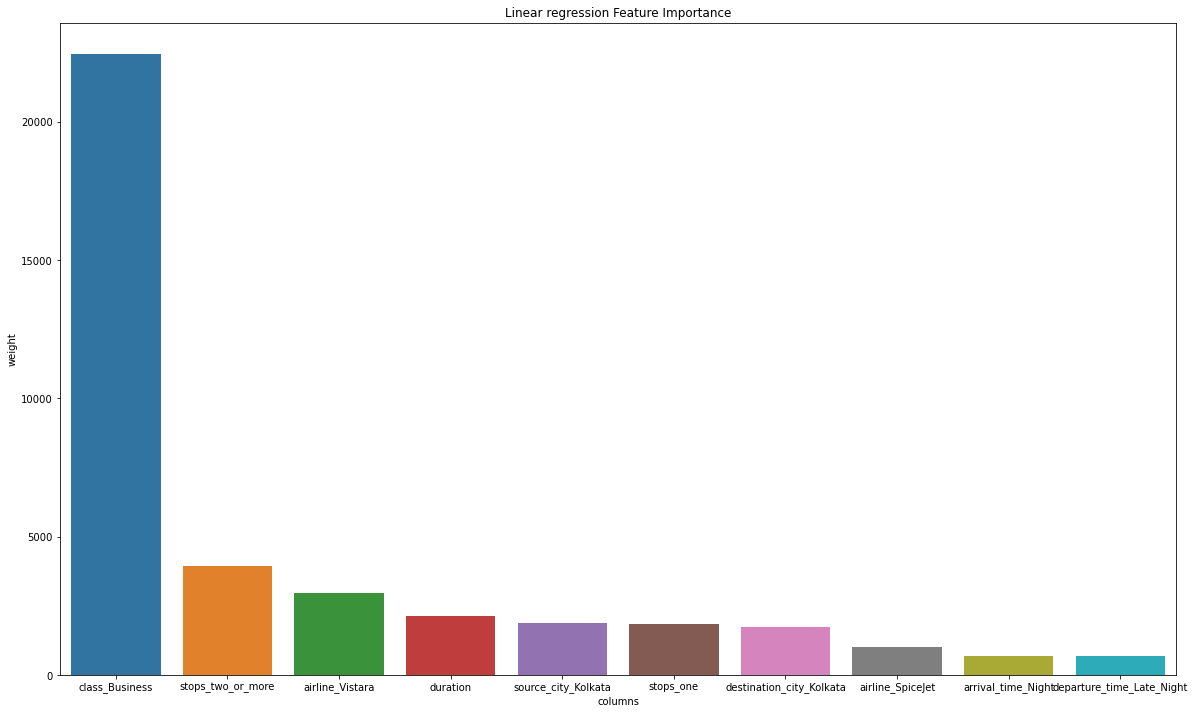

In [106]:
plt.figure(figsize=(20,12))
plt.title('Linear regression Feature Importance')
sns.barplot(data=weights_df.head(10), x='columns', y='weight',);

In [107]:
from xgboost import XGBRegressor

In [108]:
# Create the model
xr1 = XGBRegressor(n_jobs=5,learning_rate=0.1,max_depth=10,random_state=42)
# Fit the model
xr1.fit(train_inputs,train_targets)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=10, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=5,
             num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [109]:
xr1_train_preds = xr1.predict(train_inputs)
xr1_train_rmse = mean_squared_error(train_targets,xr1_train_preds,squared=False)
xr1_val_preds = xr1.predict(val_inputs)
xr1_val_rmse = mean_squared_error(val_targets,xr1_val_preds,squared=False)
print('Train RMSE: {}, Validation RMSE: {}'.format(xr1_train_rmse, xr1_val_rmse))

Train RMSE: 2159.510468496356, Validation RMSE: 2482.0463428356625


In [110]:
xr1_importance_df = pd.DataFrame({
    'feature': train_inputs.columns,
    'importance': xr1.feature_importances_
}).sort_values('importance', ascending=False)

<AxesSubplot:xlabel='importance', ylabel='feature'>

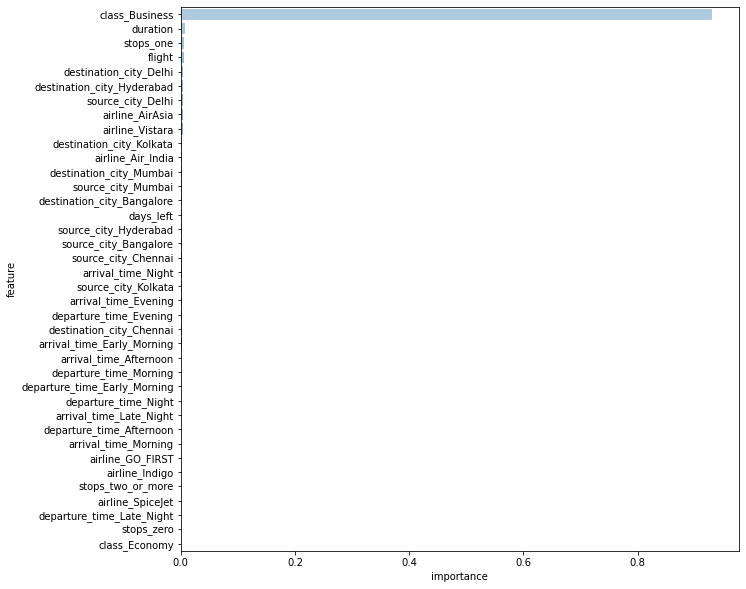

In [111]:
plt.figure(figsize=(10, 10))
sns.barplot(data=xr1_importance_df, x='importance', y='feature',palette="Blues_d",)

In [112]:
from sklearn.ensemble import RandomForestRegressor
# Create the model
rf1 = RandomForestRegressor(random_state=42)
# Fit the model
rf1.fit(train_inputs,train_targets)

RandomForestRegressor(random_state=42)

In [113]:
rf1_train_preds = rf1.predict(train_inputs)
rf1_train_rmse = mean_squared_error(train_targets,rf1_train_preds,squared=False)
rf1_val_preds = rf1.predict(val_inputs)
rf1_val_rmse = mean_squared_error(val_targets,rf1_val_preds,squared=False)
print('Train RMSE: {}, Validation RMSE: {}'.format(rf1_train_rmse, rf1_val_rmse))

Train RMSE: 876.4912655539762, Validation RMSE: 2355.1299236626614


In [114]:
rf1_importance_df = pd.DataFrame({
    'feature': train_inputs.columns,
    'importance': rf1.feature_importances_
}).sort_values('importance', ascending=False)

<AxesSubplot:xlabel='importance', ylabel='feature'>

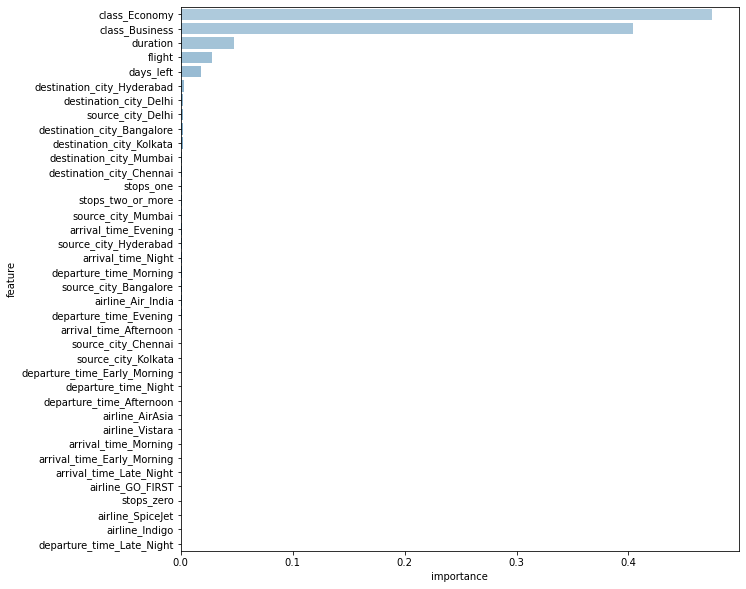

In [115]:
plt.figure(figsize=(10, 10))
sns.barplot(data=rf1_importance_df, x='importance', y='feature',palette="Blues_d",)

In [116]:
# hyper parameter tuning 

In [117]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 100, num = 3)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 45, num = 3)]
# Minimum number of samples required to split a node
min_samples_split = [5, 10]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}

print(random_grid)

{'n_estimators': [20, 60, 100], 'max_features': ['auto', 'sqrt'], 'max_depth': [1, 23, 45], 'min_samples_split': [5, 10]}


In [118]:
# Use the random grid to search for best hyperparameters

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf1, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = -1, scoring='neg_mean_squared_error')
# Fit the random search model
rf_random.fit(train_inputs, train_targets)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [1, 23, 45],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [5, 10],
                                        'n_estimators': [20, 60, 100]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [119]:
cvres2 = rf_random.cv_results_
for mean_score, params in zip(cvres2["mean_test_score"], cvres2["params"]):
    print(np.sqrt(-mean_score), params)

2541.6892430817193 {'n_estimators': 100, 'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 45}
2359.111996602431 {'n_estimators': 60, 'min_samples_split': 5, 'max_features': 'auto', 'max_depth': 23}
2346.312676035523 {'n_estimators': 100, 'min_samples_split': 5, 'max_features': 'auto', 'max_depth': 45}
2591.1748059766946 {'n_estimators': 20, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 45}
2381.756282093091 {'n_estimators': 60, 'min_samples_split': 10, 'max_features': 'auto', 'max_depth': 23}
2558.824308981671 {'n_estimators': 60, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 45}
2617.8716739623355 {'n_estimators': 20, 'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 23}
2389.395952238483 {'n_estimators': 20, 'min_samples_split': 5, 'max_features': 'auto', 'max_depth': 23}
15213.445944122835 {'n_estimators': 100, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 1}
2379.024792295497 {'n_estimators': 100, 'min_samples_sp

In [120]:
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 5,
 'max_features': 'auto',
 'max_depth': 45}

In [121]:
rf2 = RandomForestRegressor(max_depth=45, max_features='auto', min_samples_split=5,n_estimators=100, random_state=42)
# Train the model
rf2.fit(train_inputs,train_targets)

RandomForestRegressor(max_depth=45, min_samples_split=5, random_state=42)

In [122]:
rf2_train_preds = rf2.predict(train_inputs)
rf2_train_rmse = mean_squared_error(train_targets,rf2_train_preds,squared=False)
rf2_val_preds = rf2.predict(val_inputs)
rf2_val_rmse = mean_squared_error(val_targets,rf2_val_preds,squared=False)
print('Train RMSE: {}, Validation RMSE: {}'.format(rf2_train_rmse, rf2_val_rmse))

Train RMSE: 1287.3219556233416, Validation RMSE: 2326.8857300815407


In [123]:
rf2_importance_df = pd.DataFrame({
    'feature': train_inputs.columns,
    'importance': rf2.feature_importances_
}).sort_values('importance', ascending=False)

<AxesSubplot:xlabel='importance', ylabel='feature'>

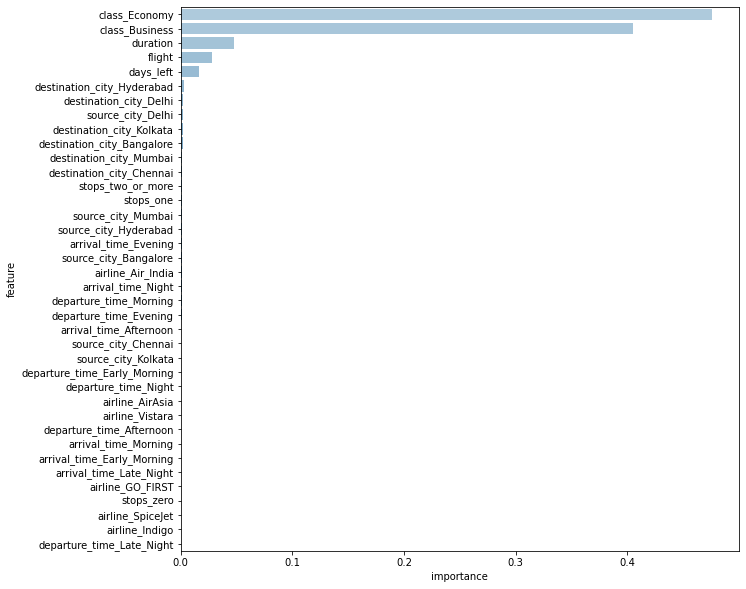

In [124]:
plt.figure(figsize=(10, 10))
sns.barplot(data=rf2_importance_df, x='importance', y='feature',palette="Blues_d",)

In [128]:
pickle.dump(xr1, open('model.pkl','wb'))

# Loading model to compare the results
model = pickle.load(open('model.pkl','rb'))
